<a href="https://colab.research.google.com/github/gabikir99/Garbage_classification/blob/main/Garbage_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

with zipfile.ZipFile('/content/drive/MyDrive/yolo_resplit.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("Using CPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA L4
Memory: 22.2 GB


In [ ]:
from ultralytics import YOLO
import optuna
import yaml
import pandas as pd
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the data.yaml file
with open('/content/yolo_resplit/data.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Dataset Configuration:")
print("=" * 40)
for key, value in config.items():
    print(f"{key}: {value}")

# Store class names for easy access
class_names = config['names']
num_classes = len(class_names)

print(f"\nWe have {num_classes} classes:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Dataset Configuration:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 6
names: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']
roboflow: {'workspace': 'material-identification', 'project': 'garbage-classification-3', 'version': 2, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/material-identification/garbage-classification-3/dataset/2'}

We have 6 classes:
  0: BIODEGRADABLE
  1: CARDBOARD
  2: GLASS
  3: METAL
  4: PAPER
  5: PLASTIC


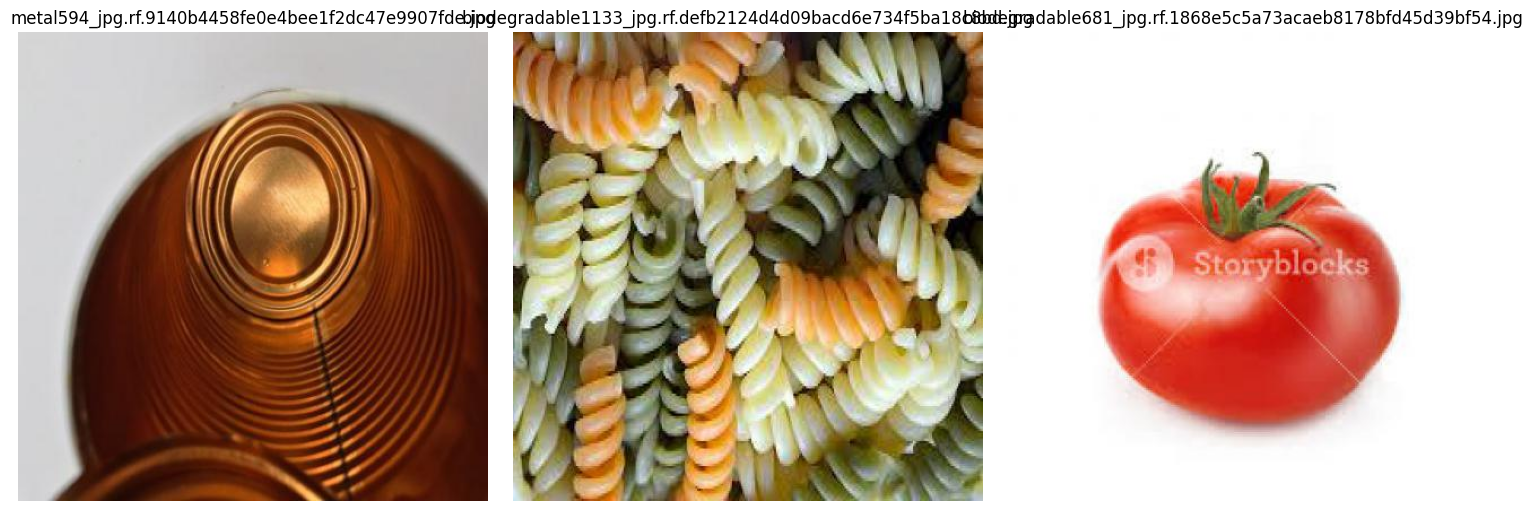

In [ ]:
from matplotlib.image import imread

train_path = '/content/yolo_resplit/train/images/'
image_list = os.listdir(train_path)

plt.figure(figsize=(15,5))
for i in range(3):
  image_path = train_path + image_list[i]
  image = imread(image_path)

  plt.subplot(1,3,i+1)
  plt.imshow(image)
  plt.title(image_list[i])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from math import e
import pandas as pd
import os

def objective(trial):
    lr0 = trial.suggest_loguniform('lr0', 1e-5, 1e-1)
    momentum = trial.suggest_uniform('momentum', 0.6, 0.95)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    mosaic = trial.suggest_uniform('mosaic', 0.0, 1.0)
    hsv_h = trial.suggest_uniform('hsv_h', 0.0, 0.5)
    hsv_s = trial.suggest_uniform('hsv_s', 0.0, 1.0)
    hsv_v = trial.suggest_uniform('hsv_v', 0.0, 1.0)
    flipud = trial.suggest_uniform('flipud', 0.0, 1.0)
    erasing = trial.suggest_uniform('erasing', 0.0, 1.0)

    trial_name = f'trial_{trial.number}'

    model = YOLO('yolov8s.pt')

    results = model.train(
        data='/content/yolo_resplit/data.yaml',
        epochs=60,
        patience=10,
        imgsz=416,
        batch=32,
        workers=4,
        freeze=10,
        project='optuna',
        name=f'trial_{trial.number}',
        exist_ok=True,
        pretrained=True,
        amp=True,
        lr0=lr0,
        momentum=momentum,
        weight_decay=weight_decay,
        mosaic=mosaic,
        hsv_h=hsv_h,
        hsv_s=hsv_s,
        hsv_v=hsv_v,
        flipud=flipud,
        erasing=erasing,
    )

    results_csv = os.path.join('optuna', trial_name, 'results.csv')

    if os.path.exists(results_csv):
      df = pd.read_csv(results_csv)
      df.columns = df.columns.str.strip()
      map_col = next((col for col in df.columns if 'mAP' in col and '50' in col), None)

      if map_col:
          return float(df[map_col].dropna().values[-1])
      else:
          return 0.0
    else:
      return 0.0

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, timeout=7200)

print("Best mAP@0.5:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

[I 2025-07-17 17:40:26,557] A new study created in memory with name: no-name-56f433fc-6d52-4bdc-a9c7-b3e6a844e1f9


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_resplit/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.18751737734738005, exist_ok=True, fliplr=0.5, flipud=0.2235868248348737, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.027754243942703427, hsv_s=0.6797886346836178, hsv_v=0.24702187890838123, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1.7259366342919262e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.8100317289152179, mosaic=0.8881600811452585, multi_scale=False, name=trial_0, nbs=64, nms=False, o

train: Scanning /content/yolo_resplit/train/labels.cache... 7318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7318/7318 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 223.3±54.2 MB/s, size: 18.6 KB)


val: Scanning /content/yolo_resplit/valid/labels.cache... 1573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1573/1573 [00:00<?, ?it/s]


Plotting labels to optuna/trial_0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1.7259366342919262e-05' and 'momentum=0.8100317289152179' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=6.569099395297855e-05), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to optuna/trial_0
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.81G      1.342      1.937      1.342        211        416: 100%|██████████| 229/229 [00:26<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

                   all       1573      11571      0.459      0.381       0.36      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      6.13G      1.346      1.473      1.341        197        416: 100%|██████████| 229/229 [00:24<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]

                   all       1573      11571      0.527      0.407       0.41      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      6.13G      1.342       1.42      1.336        136        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all       1573      11571      0.534      0.406      0.424      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      6.13G      1.329      1.367      1.332        141        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]

                   all       1573      11571      0.556      0.426      0.452      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      6.13G      1.305      1.295      1.319        182        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]

                   all       1573      11571      0.592      0.436       0.47      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      6.13G      1.297      1.263       1.31        402        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.584       0.44      0.473       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      6.13G      1.258      1.223      1.293        330        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


                   all       1573      11571      0.598      0.452      0.493      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      6.13G       1.26      1.186      1.287        130        416: 100%|██████████| 229/229 [00:24<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]

                   all       1573      11571      0.614      0.449      0.494      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      6.13G      1.233      1.171      1.276        251        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all       1573      11571      0.642      0.462      0.517      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      6.13G      1.234      1.151      1.272        468        416: 100%|██████████| 229/229 [00:24<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all       1573      11571       0.66      0.457      0.531      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      6.13G      1.234      1.124      1.269        230        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


                   all       1573      11571      0.649      0.466      0.518      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      6.13G       1.21      1.106      1.257        174        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.645      0.477      0.525      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      6.13G      1.211      1.102      1.261        197        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all       1573      11571      0.649      0.492       0.54      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      6.13G        1.2      1.072      1.248        194        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.652      0.482      0.542       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      6.13G      1.196      1.058      1.243        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.659      0.486      0.544      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      6.13G      1.197      1.041      1.241        162        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.644      0.502      0.549      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      6.13G      1.179      1.037      1.233        235        416: 100%|██████████| 229/229 [00:23<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.674      0.492       0.56       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      6.13G      1.194      1.027      1.236        256        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


                   all       1573      11571      0.666      0.493      0.558      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      6.13G      1.182      1.013      1.229        203        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.643      0.512      0.557      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      6.13G      1.183      1.016      1.231        251        416: 100%|██████████| 229/229 [00:24<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.687      0.497      0.565      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      6.13G      1.186      1.014      1.234        201        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.653      0.498      0.551      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      6.13G      1.154     0.9934      1.218        179        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.669      0.504      0.563      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      6.13G      1.162     0.9831      1.218        212        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.666      0.502      0.571      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      6.13G      1.147     0.9809      1.213        253        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.687      0.504      0.568      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      6.13G      1.167     0.9714      1.216        322        416: 100%|██████████| 229/229 [00:24<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.681      0.504       0.57      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      6.13G       1.15     0.9694      1.214        158        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571       0.69      0.511      0.574      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      6.13G      1.145     0.9623      1.209        185        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.676      0.512      0.572        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      6.13G      1.154     0.9486      1.211        189        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.671      0.528      0.576      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      6.13G      1.139     0.9413      1.199        307        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.708      0.499      0.571      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      6.13G       1.14     0.9322      1.202        211        416: 100%|██████████| 229/229 [00:24<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.668      0.517      0.572      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      6.13G      1.131     0.9293      1.197        183        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.679      0.517      0.574      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      6.13G      1.137     0.9189      1.196        307        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.697      0.514      0.579      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      6.13G      1.137     0.9154      1.198        246        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571       0.67      0.524      0.575      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      6.13G      1.132     0.9149      1.194        250        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.687      0.517      0.582      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      6.13G      1.121     0.9016       1.19        165        416: 100%|██████████| 229/229 [00:24<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.703      0.512      0.575      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      6.13G      1.113     0.8967      1.187        232        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


                   all       1573      11571      0.711      0.512      0.581      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      6.13G      1.121     0.8966      1.188        263        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.707      0.514      0.587      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      6.13G      1.107     0.8848      1.184        207        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.703      0.519      0.583       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      6.13G      1.108     0.8849      1.181        150        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.695      0.523       0.59      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      6.13G      1.105     0.8766       1.18        236        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.705      0.522      0.587      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      6.13G      1.105     0.8769       1.18        278        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.719      0.513      0.592      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      6.13G      1.103     0.8778      1.181        322        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.697      0.528      0.586      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      6.13G      1.092     0.8652      1.177        213        416: 100%|██████████| 229/229 [00:23<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all       1573      11571      0.706      0.523      0.589      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      6.13G      1.118     0.8713      1.181        227        416: 100%|██████████| 229/229 [00:23<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571       0.69      0.524      0.588      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      6.13G      1.105     0.8604      1.174        141        416: 100%|██████████| 229/229 [00:24<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.695      0.527      0.587      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      6.13G        1.1     0.8559      1.177        171        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]

                   all       1573      11571      0.696      0.531       0.59      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      6.13G      1.094     0.8395      1.166        230        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]


                   all       1573      11571      0.688      0.535      0.589      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      6.13G       1.08     0.8425      1.169        271        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.712       0.52      0.592      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      6.13G      1.091     0.8426      1.167        189        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


                   all       1573      11571      0.694      0.533      0.596      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      6.13G       1.08     0.8364      1.172        283        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571       0.69      0.527      0.589      0.418
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      6.13G      1.098     0.7716      1.166        235        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


                   all       1573      11571      0.692      0.534      0.591      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      6.13G      1.086     0.7647      1.162        169        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.702      0.524      0.591       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      6.13G      1.086     0.7494      1.158         87        416: 100%|██████████| 229/229 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.705      0.531      0.596      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      6.13G      1.095     0.7524      1.155        211        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]


                   all       1573      11571       0.69      0.538      0.597      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      6.13G      1.087     0.7527      1.159         68        416: 100%|██████████| 229/229 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571        0.7      0.535      0.598      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      6.13G      1.085     0.7415      1.152        243        416: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


                   all       1573      11571      0.715      0.526      0.597      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      6.13G      1.072     0.7341      1.154        183        416: 100%|██████████| 229/229 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.705      0.527      0.596      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      6.13G      1.078     0.7295       1.15        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]

                   all       1573      11571      0.707      0.526      0.595      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      6.13G       1.06     0.7225      1.145         93        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.695      0.534      0.596      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      6.13G      1.056     0.7149      1.139        106        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571       0.69      0.538      0.596      0.423

60 epochs completed in 0.536 hours.
Optimizer stripped from optuna/trial_0/weights/last.pt, 22.5MB
Optimizer stripped from optuna/trial_0/weights/best.pt, 22.5MB

Validating optuna/trial_0/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


                   all       1573      11571      0.697      0.535      0.598      0.425
         BIODEGRADABLE        348       7169      0.774      0.475      0.582       0.33
             CARDBOARD        231        736      0.589      0.432      0.489      0.368
                 GLASS        406       1234      0.765      0.605      0.679      0.515
                 METAL        290        856      0.664      0.631      0.658      0.485
                 PAPER        266        735      0.737      0.487      0.567       0.44
               PLASTIC        223        841      0.654      0.582      0.614      0.413
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to optuna/trial_0


[I 2025-07-17 18:12:57,435] Trial 0 finished with value: 0.59645 and parameters: {'lr0': 1.7259366342919262e-05, 'momentum': 0.8100317289152179, 'weight_decay': 6.569099395297855e-05, 'mosaic': 0.8881600811452585, 'hsv_h': 0.027754243942703427, 'hsv_s': 0.6797886346836178, 'hsv_v': 0.24702187890838123, 'flipud': 0.2235868248348737, 'erasing': 0.18751737734738005}. Best is trial 0 with value: 0.59645.


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_resplit/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.45348228747132624, exist_ok=True, fliplr=0.5, flipud=0.10599904237782753, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.09424400873980399, hsv_s=0.48537027050390624, hsv_v=0.09474285802145799, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00011102261662539489, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.6484566273131462, mosaic=0.949200119945737, multi_scale=False, name=trial_1, nbs=64, nms=False, o

train: Scanning /content/yolo_resplit/train/labels.cache... 7318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7318/7318 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 251.1±75.4 MB/s, size: 18.6 KB)


val: Scanning /content/yolo_resplit/valid/labels.cache... 1573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1573/1573 [00:00<?, ?it/s]


Plotting labels to optuna/trial_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00011102261662539489' and 'momentum=0.6484566273131462' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0015088263090811392), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to optuna/trial_1
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.29G      1.328      1.939      1.337        184        416: 100%|██████████| 229/229 [00:26<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]


                   all       1573      11571      0.421      0.372       0.34       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      6.61G      1.326      1.458      1.333        103        416: 100%|██████████| 229/229 [00:24<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

                   all       1573      11571      0.499      0.393      0.406       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      6.62G      1.319      1.403      1.325        188        416: 100%|██████████| 229/229 [00:24<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]

                   all       1573      11571      0.499      0.414      0.411      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      6.62G      1.325      1.354      1.325        136        416: 100%|██████████| 229/229 [00:24<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all       1573      11571      0.576      0.412       0.45      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      6.62G      1.292      1.318      1.314        233        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all       1573      11571      0.606      0.437      0.477      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      6.62G      1.275      1.264      1.298        156        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.589      0.445      0.489      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      6.62G      1.242      1.205      1.282        211        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.622      0.458      0.504      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      6.62G      1.256      1.192      1.273        195        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all       1573      11571      0.629      0.469       0.52      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      6.62G      1.235      1.181      1.273        382        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.611      0.483      0.522      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      6.62G      1.232      1.144      1.265        215        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.628      0.474      0.528      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      6.62G      1.208      1.121      1.258        342        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.665      0.462       0.53      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      6.62G      1.218      1.097      1.253        213        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


                   all       1573      11571      0.636      0.476      0.525      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      6.62G      1.206      1.099      1.248        143        416: 100%|██████████| 229/229 [00:23<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.635      0.477      0.528      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      6.63G      1.203      1.071      1.241        280        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all       1573      11571      0.669      0.477      0.536      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      6.65G      1.188      1.059      1.237        175        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all       1573      11571      0.648      0.497      0.548       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      6.65G      1.184       1.05      1.236        221        416: 100%|██████████| 229/229 [00:24<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.684      0.456      0.541       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      6.65G      1.172      1.047      1.235        242        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.647      0.505      0.552      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      6.65G      1.169      1.038      1.232        189        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.663       0.49      0.549      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      6.65G      1.165      1.022      1.226        192        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.659      0.499      0.552      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      6.65G      1.153     0.9966      1.219         98        416: 100%|██████████| 229/229 [00:23<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.676      0.489      0.554       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      6.65G      1.163      1.002       1.22        218        416: 100%|██████████| 229/229 [00:24<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.655      0.489      0.548      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      6.65G      1.165     0.9813      1.215        288        416: 100%|██████████| 229/229 [00:24<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.673      0.512      0.572      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      6.65G      1.145     0.9898      1.216        209        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.671      0.495      0.562      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      6.65G      1.132     0.9742      1.204        262        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571       0.69      0.489      0.561      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      6.65G      1.147     0.9568      1.206        274        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.663      0.516      0.566       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      6.65G       1.13     0.9525        1.2        229        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.686      0.507      0.564      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      6.65G      1.136     0.9586      1.204        220        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.684      0.503       0.57      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      6.65G      1.125     0.9364      1.195        151        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.695      0.498       0.57      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      6.65G       1.11     0.9406      1.196        372        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.659      0.514      0.567      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      6.65G      1.127     0.9308      1.195        212        416: 100%|██████████| 229/229 [00:24<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.679      0.518      0.577      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      6.65G       1.12     0.9174      1.191        350        416: 100%|██████████| 229/229 [00:24<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.695      0.504      0.576      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      6.65G      1.111     0.9187       1.19        208        416: 100%|██████████| 229/229 [00:24<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.677      0.512      0.575      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      6.65G      1.104     0.9038      1.185        242        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.676       0.52      0.581      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      6.65G      1.113     0.9023      1.189        214        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.672      0.529      0.585      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      6.65G      1.111     0.8988      1.183        277        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571      0.683      0.515      0.579      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      6.65G      1.099     0.8976      1.183        160        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]

                   all       1573      11571      0.692      0.518      0.582      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      6.65G      1.107     0.8855      1.183        417        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.678      0.527      0.579      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      6.65G      1.091     0.8856      1.179        266        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.684       0.53      0.587      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      6.65G      1.086     0.8735      1.174        388        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.697      0.514      0.578      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      6.65G      1.094     0.8725      1.178        252        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.704      0.509      0.578      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      6.65G      1.079     0.8612      1.168        170        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


                   all       1573      11571      0.685      0.526      0.585      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      6.65G      1.074     0.8599       1.17        200        416: 100%|██████████| 229/229 [00:23<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all       1573      11571      0.695      0.523      0.586      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      6.65G      1.085     0.8495      1.167        346        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.686      0.523       0.58       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      6.65G      1.079     0.8563      1.169        233        416: 100%|██████████| 229/229 [00:24<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571       0.68      0.536      0.589      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      6.65G      1.083     0.8497      1.166        212        416: 100%|██████████| 229/229 [00:23<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]

                   all       1573      11571      0.682      0.529      0.589      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      6.65G      1.083     0.8472      1.169        172        416: 100%|██████████| 229/229 [00:24<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all       1573      11571      0.685      0.532      0.587      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      6.65G      1.061      0.839      1.162        167        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.693      0.527      0.589      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      6.65G      1.072     0.8289      1.155        296        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


                   all       1573      11571      0.699      0.523      0.585      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      6.65G      1.075     0.8298      1.159        197        416: 100%|██████████| 229/229 [00:23<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.697      0.525      0.588      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      6.65G      1.063     0.8336       1.16        224        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571      0.694      0.525      0.588      0.418


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      6.65G      1.081      0.765      1.158        235        416: 100%|██████████| 229/229 [00:24<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.696      0.528      0.587      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      6.65G      1.072     0.7565      1.154        169        416: 100%|██████████| 229/229 [00:24<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.697      0.529      0.587      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      6.65G      1.071     0.7464      1.152         87        416: 100%|██████████| 229/229 [00:23<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.694      0.531      0.589      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      6.65G      1.075     0.7419      1.147        211        416: 100%|██████████| 229/229 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.705      0.522      0.588      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      6.65G       1.07     0.7389       1.15         68        416: 100%|██████████| 229/229 [00:23<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.716      0.521      0.591      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      6.65G      1.069     0.7341      1.144        243        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.723      0.518      0.592      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      6.65G      1.056     0.7271      1.146        183        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.705      0.527       0.59      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      6.65G      1.062     0.7178      1.143        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.708      0.521       0.59      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      6.65G      1.046     0.7138      1.137         93        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all       1573      11571      0.722      0.518      0.591      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      6.65G      1.042     0.7075      1.133        106        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.718       0.52      0.591      0.421

60 epochs completed in 0.537 hours.
Optimizer stripped from optuna/trial_1/weights/last.pt, 22.5MB
Optimizer stripped from optuna/trial_1/weights/best.pt, 22.5MB

Validating optuna/trial_1/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


                   all       1573      11571      0.716      0.521      0.591      0.422
         BIODEGRADABLE        348       7169      0.793      0.456      0.584      0.329
             CARDBOARD        231        736       0.62      0.431      0.478      0.358
                 GLASS        406       1234      0.783      0.599      0.674      0.508
                 METAL        290        856       0.68       0.63       0.66      0.487
                 PAPER        266        735      0.769      0.475      0.565      0.444
               PLASTIC        223        841      0.654      0.539      0.585      0.407
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to optuna/trial_1


[I 2025-07-17 18:45:31,615] Trial 1 finished with value: 0.59144 and parameters: {'lr0': 0.00011102261662539489, 'momentum': 0.6484566273131462, 'weight_decay': 0.0015088263090811392, 'mosaic': 0.949200119945737, 'hsv_h': 0.09424400873980399, 'hsv_s': 0.48537027050390624, 'hsv_v': 0.09474285802145799, 'flipud': 0.10599904237782753, 'erasing': 0.45348228747132624}. Best is trial 0 with value: 0.59645.


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_resplit/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.3943584503190254, exist_ok=True, fliplr=0.5, flipud=0.17048392297407733, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.10974394060016474, hsv_s=0.8764565855659633, hsv_v=0.11367858896393757, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001295671197363591, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.6229792168808128, mosaic=0.2439045706890065, multi_scale=False, name=trial_2, nbs=64, nms=False, ops

train: Scanning /content/yolo_resplit/train/labels.cache... 7318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7318/7318 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 290.0±78.5 MB/s, size: 18.6 KB)


val: Scanning /content/yolo_resplit/valid/labels.cache... 1573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1573/1573 [00:00<?, ?it/s]


Plotting labels to optuna/trial_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001295671197363591' and 'momentum=0.6229792168808128' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1.0751375945721857e-05), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to optuna/trial_2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.43G      1.373      2.073      1.363        149        416: 100%|██████████| 229/229 [00:26<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

                   all       1573      11571      0.476      0.363      0.348      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      6.24G      1.403      1.594      1.384        113        416: 100%|██████████| 229/229 [00:24<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all       1573      11571      0.507      0.399      0.404      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      6.25G       1.41      1.509      1.386         92        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all       1573      11571      0.511      0.398      0.414      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      6.25G      1.384      1.484       1.37        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.10it/s]

                   all       1573      11571      0.582      0.426      0.459      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      6.28G      1.371        1.4       1.36        120        416: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.12it/s]

                   all       1573      11571      0.586      0.428      0.461      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      6.28G      1.347      1.334      1.339        438        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]

                   all       1573      11571      0.586      0.453      0.486      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      6.28G      1.313      1.277      1.314        221        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]

                   all       1573      11571      0.611      0.457      0.497      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      6.28G      1.305      1.245      1.309        103        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.18it/s]

                   all       1573      11571      0.596      0.467      0.499       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      6.28G      1.304      1.224      1.303        309        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571       0.63      0.457      0.517      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      6.28G      1.289      1.193      1.296         66        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]

                   all       1573      11571      0.639      0.472      0.523      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      6.28G      1.271      1.162      1.287        353        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


                   all       1573      11571       0.64      0.469      0.517      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      6.28G      1.261      1.158       1.29         85        416: 100%|██████████| 229/229 [00:23<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.639      0.479      0.527      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      6.28G      1.262      1.142       1.28        187        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.18it/s]

                   all       1573      11571      0.631      0.479      0.526      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      6.28G      1.243       1.12      1.272        302        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.657      0.476      0.531      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      6.28G      1.235       1.09      1.262        147        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


                   all       1573      11571      0.649      0.477      0.529      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      6.28G      1.231      1.084       1.26        167        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


                   all       1573      11571      0.676      0.466      0.534      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      6.28G       1.21      1.059      1.248        208        416: 100%|██████████| 229/229 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.628      0.498      0.541      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      6.28G      1.229       1.05      1.258         82        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.678       0.48       0.54      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      6.28G      1.214      1.041      1.244        142        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.653        0.5       0.55      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      6.28G      1.199      1.031      1.244        198        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.641      0.494      0.543      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      6.28G      1.207      1.028      1.241        154        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.651      0.496       0.55      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      6.28G      1.196      1.006      1.233        109        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.657      0.505      0.557      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      6.28G      1.198      1.008      1.237        271        416: 100%|██████████| 229/229 [00:23<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.686      0.502      0.562      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      6.28G      1.186     0.9874      1.227        132        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.669      0.502      0.557      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      6.28G      1.199     0.9792      1.226         93        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571       0.67      0.493       0.55      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      6.28G      1.184     0.9734      1.222        210        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.697      0.493      0.563      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      6.28G      1.169      0.972      1.223        160        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.688      0.496      0.563      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      6.28G      1.166     0.9499      1.211         69        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.683      0.495      0.561      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      6.28G      1.189     0.9565       1.22        286        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.696      0.499      0.565      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      6.28G      1.178     0.9429      1.212         96        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.668      0.511      0.567      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      6.28G      1.164     0.9309      1.209        104        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571       0.67      0.515       0.57      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      6.28G      1.148     0.9261      1.204        177        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.677      0.508      0.567      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      6.28G      1.152     0.9105      1.202        118        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.678      0.508      0.567      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      6.28G      1.152     0.9119      1.202        102        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571       0.69      0.505      0.572      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      6.28G      1.136      0.895      1.191        147        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.689      0.502      0.566      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      6.28G      1.129     0.8941      1.191        411        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


                   all       1573      11571      0.693      0.505      0.571        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      6.28G      1.136     0.8839      1.199        278        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.681      0.511      0.572      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      6.28G      1.137     0.8887      1.195        171        416: 100%|██████████| 229/229 [00:23<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.699      0.507      0.573      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      6.28G      1.128     0.8754      1.188        173        416: 100%|██████████| 229/229 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all       1573      11571       0.69      0.515      0.574      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      6.28G      1.119     0.8707      1.187        244        416: 100%|██████████| 229/229 [00:23<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.697      0.508      0.573      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      6.28G      1.109     0.8621      1.182         83        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.673      0.525      0.578      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      6.28G      1.088     0.8548      1.178        205        416: 100%|██████████| 229/229 [00:23<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571      0.699      0.512       0.58      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      6.28G      1.119     0.8609      1.182        204        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.674      0.526      0.578      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      6.28G      1.106     0.8534      1.181        134        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.695      0.515      0.579      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      6.28G      1.113     0.8362      1.174        114        416: 100%|██████████| 229/229 [00:24<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.688      0.521      0.582       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      6.28G      1.111     0.8453      1.179        142        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.686      0.523      0.577      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      6.28G      1.097     0.8255      1.169         83        416: 100%|██████████| 229/229 [00:24<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]

                   all       1573      11571      0.694      0.521      0.578      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      6.28G      1.106     0.8293      1.163        309        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


                   all       1573      11571      0.697      0.521      0.581      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      6.28G      1.091     0.8234      1.169        124        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.685       0.53      0.584      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      6.28G      1.088     0.8188      1.161        253        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.699      0.521      0.581      0.412


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      6.28G      1.082     0.7614      1.154        235        416: 100%|██████████| 229/229 [00:24<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.703       0.52      0.581      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      6.28G      1.077      0.761      1.152        169        416: 100%|██████████| 229/229 [00:24<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.702       0.52       0.58      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      6.28G      1.073     0.7507       1.15         87        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.707      0.519      0.583      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      6.28G      1.082     0.7482      1.148        211        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.689      0.529      0.585      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      6.28G      1.074     0.7472      1.151         68        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.696      0.527      0.585      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      6.28G      1.078     0.7422      1.146        243        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571        0.7      0.521      0.586      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      6.28G      1.058     0.7371      1.147        183        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


                   all       1573      11571      0.698       0.52      0.584      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      6.28G      1.071     0.7274      1.146        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]


                   all       1573      11571      0.707      0.516      0.581      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      6.28G      1.052     0.7209      1.139         93        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571      0.703      0.521      0.582      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      6.28G       1.05     0.7183      1.135        106        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.702      0.522      0.583      0.412

60 epochs completed in 0.534 hours.
Optimizer stripped from optuna/trial_2/weights/last.pt, 22.5MB
Optimizer stripped from optuna/trial_2/weights/best.pt, 22.5MB

Validating optuna/trial_2/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


                   all       1573      11571      0.697      0.527      0.585      0.416
         BIODEGRADABLE        348       7169      0.757      0.465      0.576      0.325
             CARDBOARD        231        736      0.584      0.451      0.482      0.361
                 GLASS        406       1234      0.786      0.611      0.681      0.507
                 METAL        290        856      0.677      0.616      0.645      0.475
                 PAPER        266        735      0.738       0.46      0.547      0.425
               PLASTIC        223        841      0.637      0.558      0.581      0.401
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to optuna/trial_2


[I 2025-07-17 19:17:54,229] Trial 2 finished with value: 0.58266 and parameters: {'lr0': 0.0001295671197363591, 'momentum': 0.6229792168808128, 'weight_decay': 1.0751375945721857e-05, 'mosaic': 0.2439045706890065, 'hsv_h': 0.10974394060016474, 'hsv_s': 0.8764565855659633, 'hsv_v': 0.11367858896393757, 'flipud': 0.17048392297407733, 'erasing': 0.3943584503190254}. Best is trial 0 with value: 0.59645.


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_resplit/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4720868932938471, exist_ok=True, fliplr=0.5, flipud=0.15727979070801124, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.15011449393794063, hsv_s=0.06165056951834336, hsv_v=0.30748372100361043, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.07279157628382818, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.8510204847999261, mosaic=0.11876650789889254, multi_scale=False, name=trial_3, nbs=64, nms=False, ops

train: Scanning /content/yolo_resplit/train/labels.cache... 7318 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7318/7318 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 219.0±51.8 MB/s, size: 18.6 KB)


val: Scanning /content/yolo_resplit/valid/labels.cache... 1573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1573/1573 [00:00<?, ?it/s]


Plotting labels to optuna/trial_3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.07279157628382818' and 'momentum=0.8510204847999261' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038176324048231383), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to optuna/trial_3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.25G       1.41      2.146      1.382        144        416: 100%|██████████| 229/229 [00:27<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


                   all       1573      11571      0.452       0.36      0.327        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      6.57G      1.446      1.639      1.403        137        416: 100%|██████████| 229/229 [00:24<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


                   all       1573      11571       0.51      0.354       0.37       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      6.57G      1.426      1.559      1.398         84        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.14it/s]

                   all       1573      11571      0.497      0.362      0.386      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      6.58G      1.408      1.504      1.394         87        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]

                   all       1573      11571      0.527      0.421       0.44      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      6.58G      1.389      1.403      1.371        123        416: 100%|██████████| 229/229 [00:23<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.16it/s]

                   all       1573      11571      0.575      0.419      0.453      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      6.59G       1.36      1.353      1.353        371        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.597      0.448      0.494      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      6.59G      1.335      1.299      1.333        214        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.10it/s]

                   all       1573      11571      0.601      0.449      0.487      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      6.59G      1.332      1.268       1.33         70        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]

                   all       1573      11571      0.594      0.456      0.492      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      6.59G      1.305      1.242      1.321        293        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


                   all       1573      11571      0.622      0.458      0.505      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      6.59G      1.294      1.215       1.31         83        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all       1573      11571       0.63      0.461      0.518       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      6.59G      1.289      1.194      1.304        335        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.638      0.474      0.528      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      6.59G      1.273       1.17      1.298         60        416: 100%|██████████| 229/229 [00:23<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


                   all       1573      11571      0.641      0.467      0.526      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      6.59G      1.269      1.148      1.291         83        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.614      0.493      0.528      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      6.59G      1.269      1.122      1.284         46        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.616      0.482      0.521      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60       6.6G       1.25      1.105      1.276         89        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.654      0.471      0.528      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60       6.6G      1.242      1.103      1.276        198        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.652      0.462      0.529      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60       6.6G      1.238      1.079      1.262        234        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all       1573      11571      0.657      0.486      0.543      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       6.6G      1.246      1.065      1.268        140        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

                   all       1573      11571      0.658       0.49      0.544      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       6.6G      1.219      1.055      1.257         95        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.652      0.492      0.542      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       6.6G      1.224      1.042       1.26        200        416: 100%|██████████| 229/229 [00:23<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.638      0.495      0.541      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60       6.6G      1.209      1.031      1.249        106        416: 100%|██████████| 229/229 [00:23<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.659      0.491       0.55      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       6.6G      1.222      1.022      1.251         94        416: 100%|██████████| 229/229 [00:24<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.665      0.484      0.549      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60       6.6G      1.199      1.003      1.241        158        416: 100%|██████████| 229/229 [00:23<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.661      0.504      0.555      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       6.6G      1.192      0.992       1.23        134        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571      0.676      0.496      0.553      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60       6.6G      1.196     0.9826      1.236        198        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]

                   all       1573      11571      0.657      0.505      0.555      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60       6.6G      1.181     0.9676      1.228        241        416: 100%|██████████| 229/229 [00:23<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.659       0.51      0.561      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       6.6G      1.182     0.9697       1.23        164        416: 100%|██████████| 229/229 [00:23<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.662      0.511      0.562      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       6.6G      1.174      0.956       1.22         60        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.663        0.5       0.56      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60       6.6G       1.18     0.9496      1.225        180        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.678      0.509      0.559      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60       6.6G      1.184     0.9332      1.219        100        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571      0.663      0.515       0.57      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60       6.6G       1.16     0.9297      1.212        108        416: 100%|██████████| 229/229 [00:24<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]

                   all       1573      11571       0.68       0.51      0.567      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60       6.6G       1.15     0.9146      1.206        125        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.664      0.505      0.554      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60       6.6G       1.16     0.9147      1.209        104        416: 100%|██████████| 229/229 [00:23<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all       1573      11571       0.67      0.503      0.563      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       6.6G      1.154     0.9108       1.21         63        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571      0.687        0.5      0.566      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60       6.6G      1.142     0.8978      1.198         29        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571      0.674      0.509       0.56       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60       6.6G      1.142     0.8948      1.201        436        416: 100%|██████████| 229/229 [00:24<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.696      0.494      0.566      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       6.6G      1.152     0.8814      1.195        360        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all       1573      11571      0.683      0.503      0.562      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60       6.6G      1.143     0.8774       1.19        195        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.695      0.502       0.57      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60       6.6G      1.141     0.8826      1.197        110        416: 100%|██████████| 229/229 [00:23<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


                   all       1573      11571      0.697      0.503      0.566      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       6.6G      1.137     0.8693      1.195        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.702        0.5      0.571      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       6.6G      1.126     0.8519      1.188        123        416: 100%|██████████| 229/229 [00:23<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.692      0.514      0.574      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       6.6G       1.13     0.8466      1.183        167        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


                   all       1573      11571      0.689      0.512      0.572      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60       6.6G      1.127     0.8476      1.183        178        416: 100%|██████████| 229/229 [00:23<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.683      0.518      0.575      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       6.6G      1.106     0.8344      1.173        164        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


                   all       1573      11571      0.682       0.52      0.574      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60       6.6G      1.115     0.8301      1.181         72        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]

                   all       1573      11571      0.685       0.51      0.569      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       6.6G      1.111     0.8324      1.179        136        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all       1573      11571      0.679      0.517      0.573      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       6.6G      1.102       0.82      1.172         58        416: 100%|██████████| 229/229 [00:23<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.682      0.518      0.571      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       6.6G      1.115     0.8196      1.178        261        416: 100%|██████████| 229/229 [00:23<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all       1573      11571      0.694      0.511       0.57      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       6.6G      1.098     0.8108      1.169        120        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.684      0.518      0.574      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       6.6G      1.096     0.8088      1.166        237        416: 100%|██████████| 229/229 [00:24<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.677      0.519      0.574      0.404
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60       6.6G      1.089     0.7693       1.16        235        416: 100%|██████████| 229/229 [00:24<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]


                   all       1573      11571      0.682      0.518      0.572      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60       6.6G       1.08      0.768      1.157        169        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]


                   all       1573      11571       0.69      0.519      0.573      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60       6.6G       1.08      0.758      1.158         87        416: 100%|██████████| 229/229 [00:23<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all       1573      11571       0.69      0.517      0.575      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60       6.6G      1.086      0.754      1.153        211        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]


                   all       1573      11571      0.682      0.521      0.574      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60       6.6G       1.08     0.7553      1.155         68        416: 100%|██████████| 229/229 [00:23<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.695      0.517      0.576      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60       6.6G      1.082     0.7518      1.148        243        416: 100%|██████████| 229/229 [00:23<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all       1573      11571      0.691      0.519      0.577      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       6.6G      1.065      0.744      1.151        183        416: 100%|██████████| 229/229 [00:23<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all       1573      11571      0.705      0.513      0.577      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60       6.6G      1.078     0.7396      1.153        107        416: 100%|██████████| 229/229 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


                   all       1573      11571      0.693      0.518      0.574      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       6.6G       1.06     0.7302      1.144         93        416: 100%|██████████| 229/229 [00:23<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


                   all       1573      11571      0.691      0.514      0.575      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60       6.6G      1.052     0.7219      1.138        106        416: 100%|██████████| 229/229 [00:23<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


                   all       1573      11571      0.708      0.509      0.575      0.405

60 epochs completed in 0.534 hours.
Optimizer stripped from optuna/trial_3/weights/last.pt, 22.5MB
Optimizer stripped from optuna/trial_3/weights/best.pt, 22.5MB

Validating optuna/trial_3/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


                   all       1573      11571      0.689       0.52      0.577      0.406
         BIODEGRADABLE        348       7169      0.774       0.46      0.574      0.323
             CARDBOARD        231        736      0.584      0.428      0.467      0.349
                 GLASS        406       1234      0.749      0.606      0.662      0.489
                 METAL        290        856      0.686      0.617      0.638      0.462
                 PAPER        266        735      0.684      0.472      0.542      0.421
               PLASTIC        223        841      0.656      0.536      0.582      0.394
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to optuna/trial_3


[I 2025-07-17 19:50:18,113] Trial 3 finished with value: 0.57517 and parameters: {'lr0': 0.07279157628382818, 'momentum': 0.8510204847999261, 'weight_decay': 0.00038176324048231383, 'mosaic': 0.11876650789889254, 'hsv_h': 0.15011449393794063, 'hsv_s': 0.06165056951834336, 'hsv_v': 0.30748372100361043, 'flipud': 0.15727979070801124, 'erasing': 0.4720868932938471}. Best is trial 0 with value: 0.59645.


Best mAP@0.5: 0.59645
Best hyperparameters:
  lr0: 1.7259366342919262e-05
  momentum: 0.8100317289152179
  weight_decay: 6.569099395297855e-05
  mosaic: 0.8881600811452585
  hsv_h: 0.027754243942703427
  hsv_s: 0.6797886346836178
  hsv_v: 0.24702187890838123
  flipud: 0.2235868248348737
  erasing: 0.18751737734738005


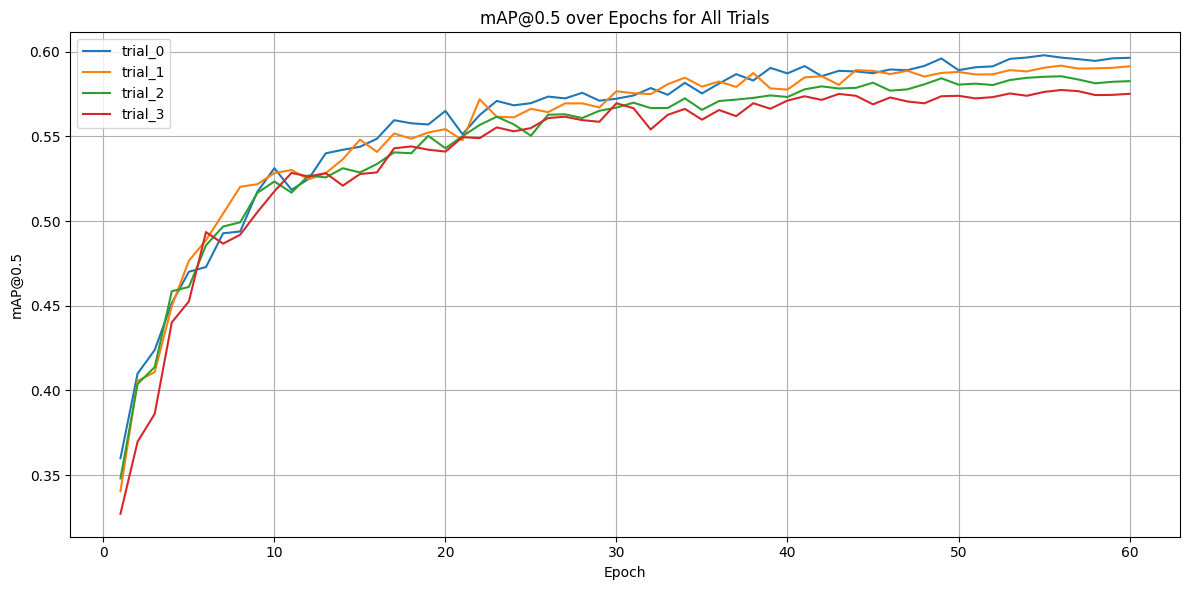

In [ ]:
trial_folder = '/content/optuna'
plt.figure(figsize=(12, 6))

for trial_name in sorted(os.listdir(trial_folder)):
    results_path = os.path.join(trial_folder, trial_name, 'results.csv')
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)
        df.columns = df.columns.str.strip()

        # Find mAP@0.5 column dynamically
        map_col = next((col for col in df.columns if 'mAP' in col and '50' in col), None)

        if map_col:
            plt.plot(df['epoch'], df[map_col], label=trial_name)

plt.title('mAP@0.5 over Epochs for All Trials')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = study.trials_dataframe(attrs=("number", "value", "params"))
df.sort_values(by='value', ascending=False).reset_index(drop=True)

,number,value,params_erasing,params_flipud,params_hsv_h,params_hsv_s,params_hsv_v,params_lr0,params_momentum,params_mosaic,params_weight_decay
0,0,0.59645,0.187517,0.223587,0.027754,0.679789,0.247022,0.000017,0.810032,0.888160,0.000066
1,1,0.59144,0.453482,0.105999,0.094244,0.485370,0.094743,0.000111,0.648457,0.949200,0.001509
2,2,0.58266,0.394358,0.170484,0.109744,0.876457,0.113679,0.000130,0.622979,0.243905,0.000011
3,3,0.57517,0.472087,0.157280,0.150114,0.061651,0.307484,0.072792,0.851020,0.118767,0.000382


In [ ]:
import shutil

shutil.make_archive('/content/yolo_optuna_outputs', 'zip', '/content/optuna')

'/content/yolo_optuna_outputs.zip'

In [ ]:
from google.colab import files

files.download('/content/yolo_optuna_outputs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = YOLO('/content/optuna/trial_1/weights/best.pt')

test_images_path = '/content/yolo_resplit/test/images'
test_images = sorted(os.listdir(test_images_path))[:5]
test_image_paths = [os.path.join(test_images_path, img) for img in test_images]

In [ ]:
for img_path in test_image_paths:
    model.predict(source=img_path, save=True, imgsz=416, conf=0.25)


image 1/1 /content/yolo_resplit/test/images/biodegradable2241_jpeg.rf.2673c611d6eed65549ec3950ee037073.jpg: 416x416 45 BIODEGRADABLEs, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_resplit/test/images/metal510_jpg.rf.e18319b62f7de96a60df125f946a09f3.jpg: 416x416 1 GLASS, 1 METAL, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_resplit/test/images/paper2172_jpg.rf.e923174e0d12a39bd51b34735da744f2.jpg: 416x416 2 PAPERs, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_resplit/test/images/glass882_jpg.rf.8a1d8f34037570ec4ed3b20d682ceb23.jpg: 416x416 4 GLASSs, 2 METALs, 7.4ms
Speed: 0.9ms preprocess, 7.4ms inference, 1.4ms postprocess per imag

In [ ]:
predict_folder = '/content/runs/detect/predict'
os.listdir(predict_folder)

['biodegradable1034_jpg.rf.d5b37a90727a7e27e2af21ba9a5c3b66.jpg',
 'biodegradable1000_jpg.rf.9407ff66b4ccd9f8eb5545be8f3225f4.jpg',
 'biodegradable104_jpg.rf.5bf2654572640ec237243cebfd54727c.jpg',
 'biodegradable1030_jpg.rf.78c782c4ec0b999752b2db645052860d.jpg',
 'biodegradable1018_jpg.rf.7096f674377109b61508f33a7c3b411d.jpg']

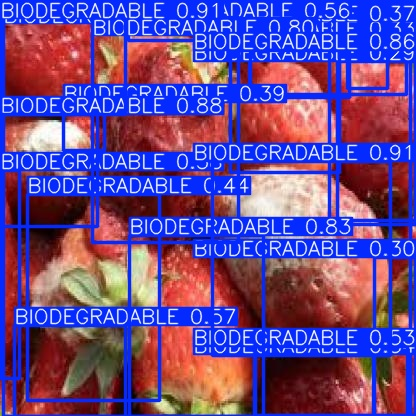

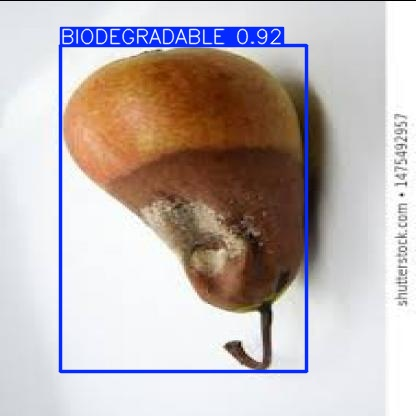

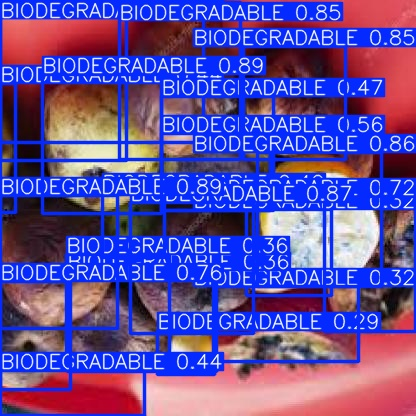

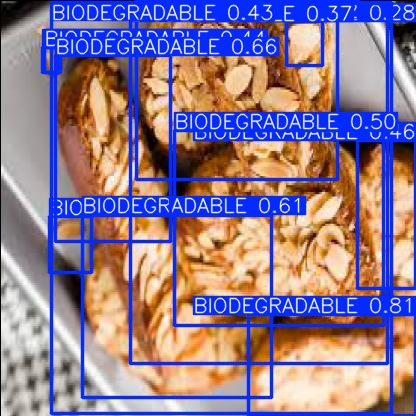

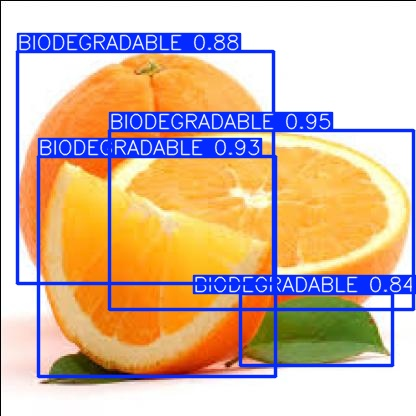

In [ ]:
from IPython.display import Image, display

predict_folder = '/content/runs/detect/predict'
predicted_images = sorted(os.listdir(predict_folder))[:5]  # first 5 sorted images

for img_name in predicted_images:
    display(Image(filename=os.path.join(predict_folder, img_name)))

In [ ]:
import random

test_images_path = '/content/yolo_resplit/test/images'
all_images = os.listdir(test_images_path)
random_images = random.sample(all_images, 5)
test_image_paths = [os.path.join(test_images_path, img) for img in random_images]

# Run predictions
model.predict(source=test_image_paths, save=True, imgsz=416, conf=0.25)


0: 416x416 1 PAPER, 1.8ms
1: 416x416 38 BIODEGRADABLEs, 1.8ms
2: 416x416 1 METAL, 1.8ms
3: 416x416 1 GLASS, 1 PLASTIC, 1.8ms
4: 416x416 1 CARDBOARD, 1.8ms
Speed: 1.5ms preprocess, 1.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'BIODEGRADABLE', 1: 'CARDBOARD', 2: 'GLASS', 3: 'METAL', 4: 'PAPER', 5: 'PLASTIC'}
 obb: None
 orig_img: array([[[199, 203, 204],
         [199, 203, 204],
         [198, 202, 203],
         ...,
         [183, 194, 198],
         [183, 194, 198],
         [183, 194, 198]],
 
        [[199, 203, 204],
         [199, 203, 204],
         [198, 202, 203],
         ...,
         [182, 193, 197],
         [183, 194, 198],
         [183, 194, 198]],
 
        [[199, 203, 204],
         [199, 203, 204],
         [198, 202, 203],
         ...,
         [182, 193, 197],
         [182, 193, 197],
         [183, 194, 198]],
 
        ...,
 
        [[164, 169, 170],
         [164, 169, 170],
         [164, 169, 170],
         ...,
         [159, 161, 162],
         [158, 160, 161],
         [158, 160, 161]],
 
        [[165, 170, 171],
         [1

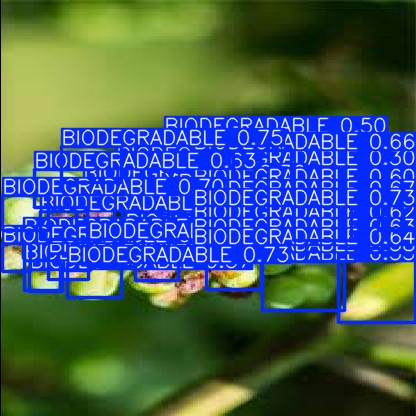

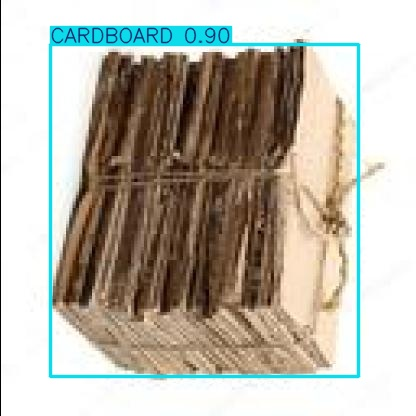

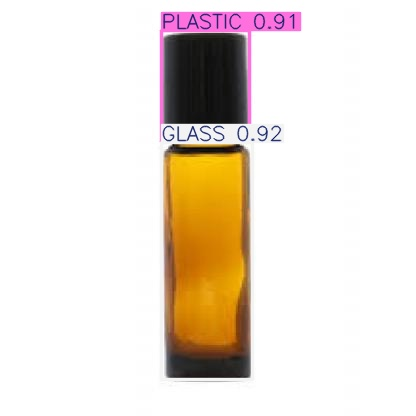

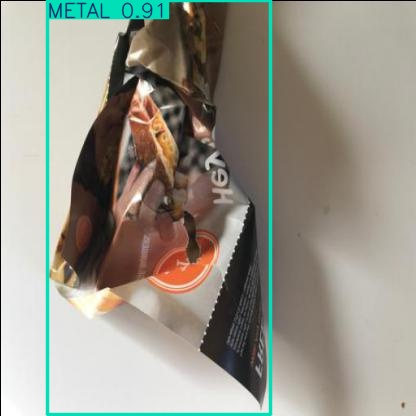

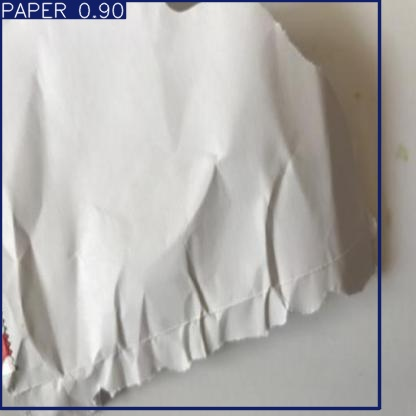

In [ ]:
latest_folder = '/content/runs/detect/predict3'
predicted_images = sorted(os.listdir(latest_folder))[:5]

for img_name in predicted_images:
    display(Image(filename=os.path.join(latest_folder, img_name)))